In [53]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os, sys

sys.path.insert(0, './../utils/')

# custom files 
import random_forest_regressor as rfr
import utilities as util
import validation as cv
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import train_test_split
from sklearn import cross_validation

%matplotlib inline

with open('../../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

In [54]:
EPA_VISUAL = """
        SELECT
            avg(arithmetic_mean) as am,
            EXTRACT(YEAR FROM CO_daily.date_local)*100 +
            EXTRACT(MONTH FROM CO_daily.date_local) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as CO_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_CO = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_CO_VISUAL = bq_assistant_CO.query_to_pandas(EPA_VISUAL)

In [55]:
df_CO_VISUAL['formatted_date'] = pd.to_datetime(df_CO_VISUAL['date'], format='%Y%m')
df_CO_VISUAL.head()

,am,date,formatted_date
0,0.508726,201712,2017-12-01
1,0.420647,201711,2017-11-01
2,0.571258,201710,2017-10-01
3,0.479866,201709,2017-09-01
4,0.518230,201708,2017-08-01


Text(0.5,1,'CO arithmetic mean between 1991 & 2017')

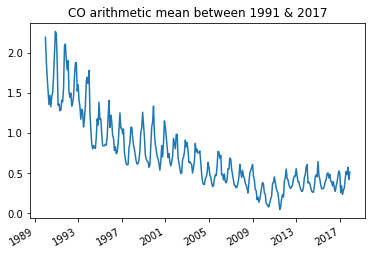

In [56]:
# plot original data 
fig, ax = plt.subplots()
ax.plot(df_CO_VISUAL['formatted_date'], df_CO_VISUAL['am'])
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
# n = 20
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('CO arithmetic mean between 1991 & 2017')

In [57]:
EPA_QUERY = """
        SELECT
            avg(arithmetic_mean) as am,
            EXTRACT(YEAR FROM CO_daily.date_local)*10000 +
            EXTRACT(MONTH FROM CO_daily.date_local)*100 + 
            EXTRACT(DAY FROM CO_daily.date_local) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.co_daily_summary` as CO_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_CO = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_CO = bq_assistant_CO.query_to_pandas(EPA_QUERY)

In [58]:
df_CO.head()

,am,date
0,0.648188,20171231
1,0.626177,20171230
2,0.563949,20171229
3,0.675906,20171228
4,0.610960,20171227


In [59]:
# find optimum regressor
regr = rfr.find_regressor(df_CO['date'].as_matrix().reshape(-1,1), df_CO['am'].values)
regr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   2.2s
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   2.2s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   2.2s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   2.8s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=175, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [60]:
df_CO.head()

,am,date
0,0.648188,20171231
1,0.626177,20171230
2,0.563949,20171229
3,0.675906,20171228
4,0.610960,20171227


In [61]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_CO['date'].to_frame(), df_CO['am'].values, test_size=0.33, random_state=42)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [62]:
cv.MSE(y_test, y_pred)

0.04245489855557771

In [63]:
tss_score = cv.Cross_Validation(df_CO['date'].to_frame(), df_CO['am'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 0.14481904370284474 
